In [13]:
# import required packages
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

# import MAGI-X packages
from magix import dynamic # dynamic module
from magix.inference import FMAGI # inferred module

## High Frequency High Noise

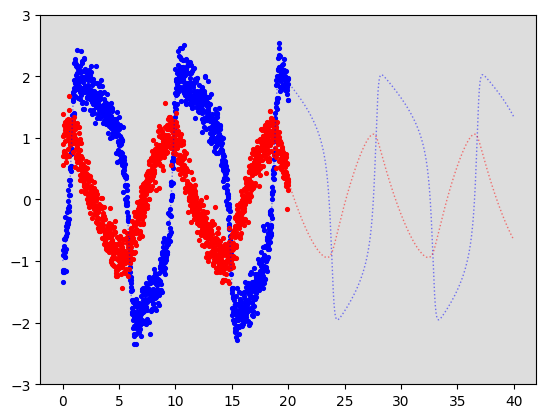

In [14]:
# FN
seed = 637077689 # random seed
example = 'fn' # example
noise = [0.2,0.2] # noise level
no_train = 1281 # number of training point

# read data
data = np.loadtxt('data/%s.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)

# observation
obs = []
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.show()

### Known Dynamic

In [15]:
# known dynamic
torch.manual_seed(seed)
# define known FitzHugh-Nagumo dynamic

def FN_change_ode(theta, change_par, change_time, x, t):
    # theta: a, b, c; x: V, R
    assert x.shape[0] == t.shape[0]
    theta0 = torch.zeros_like(t)
    theta0[t < change_time] = change_par[0]
    theta0[t >= change_time] = change_par[1]
    dVdt = theta[2]*(x[:,0]-torch.pow(x[:,0],3)/3.0+x[:,1]).reshape(-1,1)
    dRdt = -1.0/theta[2]*(x[:,0]-theta0+theta[1]*x[:,1]).reshape(-1,1)
    dxdt = torch.cat((dVdt,dRdt), 1)
    return (dxdt)


def FNode(theta, x, t):
    # theta: a, b, c; x: V, R
    dVdt = theta[2]*(x[:,0]-torch.pow(x[:,0],3)/3.0+x[:,1]).reshape(-1,1)
    dRdt = -1.0/theta[2]*(x[:,0]-theta[0]+theta[1]*x[:,1]).reshape(-1,1)
    dxdt = torch.cat((dVdt,dRdt), 1)
    return (dxdt)

theta = torch.tensor([1.,1.,5.]).double() # initial theta
change_par = [1.5, 0.5]
change_time = 10

fOde = dynamic.odeModule(FNode, theta)

# learning rate
magix_iteration = 1000
# time recording
start_time = time.time()
# call inference class
model_h0 = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 



In [16]:
# map inference
tinfer_h0, xinfer_h0 = model_h0.map(max_epoch=magix_iteration,
                                    learning_rate=1e-2,decay_learning_rate=False,
                                    robust=False,robust_eps=0.10,
                                    hyperparams_update=True,dynamic_standardization=False,
                                    verbose=True,returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 200.716821
200/1000 iteration: 11.226338
400/1000 iteration: 9.396577
600/1000 iteration: 8.522828
800/1000 iteration: 7.955437
1000/1000 iteration: 7.544908
run time: 23.10 seconds


In [21]:
tinfer = tinfer_h0
xinfer = xinfer_h0
model = model_h0

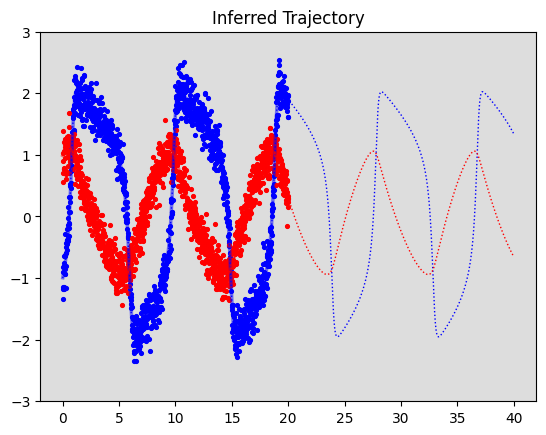

In [22]:
# inferred 
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tinfer, xinfer[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

In [23]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(trecon, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

TypeError: odeModule.forward() missing 1 required positional argument: 't'

## Low Frequency Low Noise

In [ ]:
# FN
seed = 637077689 # random seed
example = 'fn' # example
noise = [0.1,0.1] # noise level
no_train = 41 # number of training point

# read data
data = np.loadtxt('data/%s.txt' %(example))
tdata = data[:,0] # time
xdata = data[:,1:] # component values
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)

# observation
obs = []
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.show()

### Unknown Dynamic

In [ ]:
# unknown dynamic
torch.manual_seed(seed)
# define neural network dynamic
magix_node = [no_comp,512,no_comp]
fOde = dynamic.nnModule(magix_node)
# learning rate
magix_iteration = 1000
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=magix_iteration,
                           learning_rate=1e-3,decay_learning_rate=True,
                           robust=True,robust_eps=0.10,
                           hyperparams_update=True,dynamic_standardization=True,
                           verbose=True,returnX=True) 
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

In [ ]:
# inferred 
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tinfer, xinfer[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

In [ ]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(trecon, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

### Known Dynamic

In [ ]:
# known dynamic
torch.manual_seed(seed)
# define known FitzHugh-Nagumo dynamic
def FNode(theta, x):
    # theta: a, b, c; x: V, R
    dVdt = theta[2]*(x[:,0]-torch.pow(x[:,0],3)/3.0+x[:,1]).reshape(-1,1)
    dRdt = -1.0/theta[2]*(x[:,0]-theta[0]+theta[1]*x[:,1]).reshape(-1,1)
    dxdt = torch.cat((dVdt,dRdt), 1)
    return (dxdt)
theta = torch.tensor([1.,1.,5.]).double() # initial theta
fOde = dynamic.odeModule(FNode, theta)
# learning rate
magix_iteration = 1000
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=magix_iteration,
                           learning_rate=1e-2,decay_learning_rate=False,
                           robust=False,robust_eps=0.10,
                           hyperparams_update=True,dynamic_standardization=False,
                           verbose=True,returnX=True) 
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

In [ ]:
# inferred 
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tinfer, xinfer[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()

In [ ]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
xrecon = model.predict(x0,trecon) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(trecon, xrecon[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(-3,3)
plt.title('Inferred Trajectory')
plt.show()